## CNN with Adam Optimizer and a LR Scheduler
Image Transformations Used:
1. Rotation
2. Center Crop
3. Random Affiner
4. Color Jitter

Params:
1. Epochs - 30
2. Learning Rate - 0.001

In [ ]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import GTSRB
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Add CLAHE preprocessing
def clahe_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)  # Apply CLAHE
    return np.stack([enhanced_image] * 3, axis=-1)  # Convert back to 3-channel

# GTSRB Classifier Class
class GTSRBModel(nn.Module):
    def __init__(self):
        super(GTSRBModel, self).__init__()

        # Building 3 deep convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size of flattened features
        self.flatten_size = 128 * 3 * 3
        # After 3 pooling layers: 28x28 -> 14x14 -> 7x7 -> 3x3

        # Building fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 43)

        # Adding a dropout layer
        self.dropout = nn.Dropout(0.5)

    # for forward propagation
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, self.flatten_size)
        x = self.dropout(F.relu(self.bn4(self.fc1(x))))
        x = self.fc2(x)
        return x

# Image transforms while downloaing the dataset
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop(28),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Lambda(lambda img: torch.tensor(clahe_preprocess(np.array(img)), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop(28),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Lambda(lambda img: torch.tensor(clahe_preprocess(np.array(img)), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

# Lists to store loss and accuracy for training and testing dataset
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
all_preds, all_labels = [], []

# function for training the model
def train_model(model, train_loader, test_loader, num_epochs=30):
    # utilizing GPU while training the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initializing the Cross Entropy Loss and Adam Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    best_test_acc = 0.0

    # running the model for 30 epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Testing
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')


        # Saving the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            # torch.save(model, 'web-app-model.pth')  # Uncomment this line only if you want to use the model in web-app

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.3f}')
        print(f'Training Accuracy: {train_acc:.2f}%')
        print(f'Testing Accuracy: {test_acc:.2f}%')
        print(f'Best Testing Accuracy: {best_test_acc:.2f}%')
        print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}')
        print('--------------------')

        scheduler.step(test_loss)

# 'main' function to handle the execution of program
def main():
    # Loading the datasets
    train_dataset = GTSRB(root='./data', split='train', download=True, transform=train_transforms)
    test_dataset = GTSRB(root='./data', split='test', download=True, transform=test_transforms)

    # Creating the data loaders for training and Testing dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=4,
        drop_last=True
    )

    # Initialize and train model
    model = GTSRBModel()
    train_model(model, train_loader, test_loader)

if __name__ == '__main__':
    main()

100%|██████████| 187M/187M [00:09<00:00, 18.9MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:04<00:00, 19.7MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 208kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb
Epoch [1/30]
Training Loss: 0.613
Training Accuracy: 84.52%
Testing Accuracy: 91.54%
Best Testing Accuracy: 91.54%
Precision: 0.922, Recall: 0.915, F1-Score: 0.915
--------------------
Epoch [2/30]
Training Loss: 0.141
Training Accuracy: 95.93%
Testing Accuracy: 93.43%
Best Testing Accuracy: 93.43%
Precision: 0.929, Recall: 0.925, F1-Score: 0.925
--------------------
Epoch [3/30]
Training Loss: 0.099
Training Accuracy: 97.16%
Testing Accuracy: 93.15%
Best Testing Accuracy: 93.43%
Precision: 0.930, Recall: 0.927, F1-Score: 0.927
--------------------
Epoch [4/30]
Training Loss: 0.080
Training Accuracy: 97.64%
Testing Accuracy: 94.23%
Best Testing Accuracy: 94.23%
Precision: 0.933, Recall: 0.931, F1-Score: 0.930
--------------------
Epoch [5/30]
Training Loss: 0.073
Training Accuracy: 97.68%
Testing Accuracy: 94.71%
Best Testing Accuracy: 94.71%
Precision: 0.936, Recall: 0.934, F1-Score: 0.934
--------------------
Epoch [6/30]
Tr

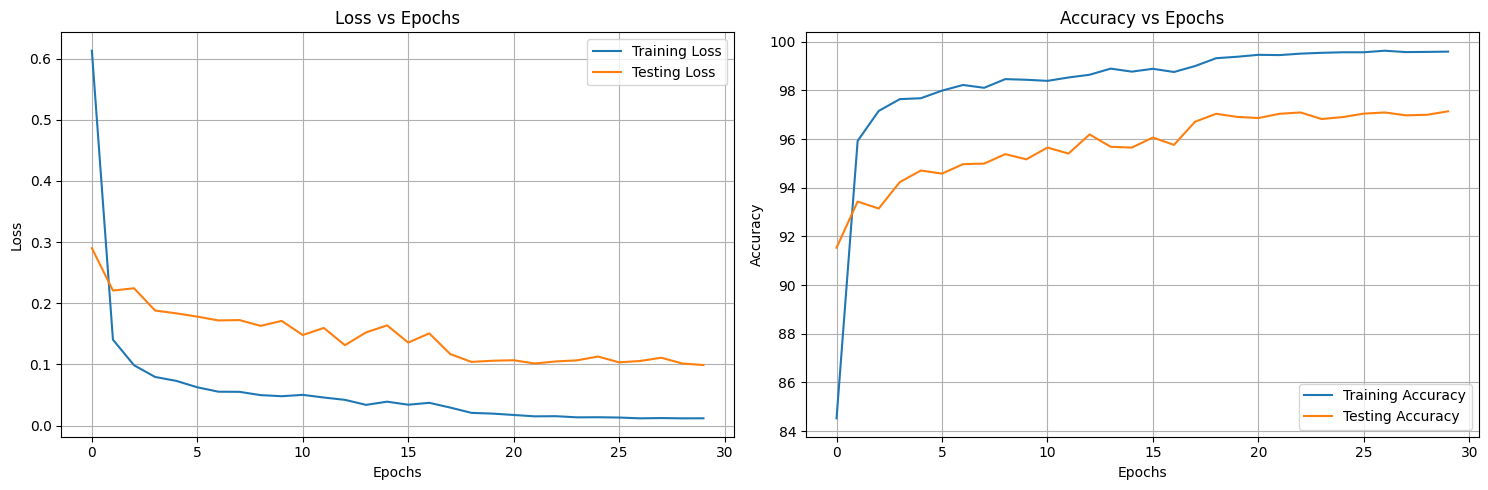

In [ ]:
# Graphs for loss vs epoch and accuracy vs epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses vs epochs
ax1.plot(train_losses, label='Training Loss')
ax1.plot(test_losses, label='Testing Loss')
ax1.set_title('Loss vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies vs epochs
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(test_accuracies, label='Testing Accuracy')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

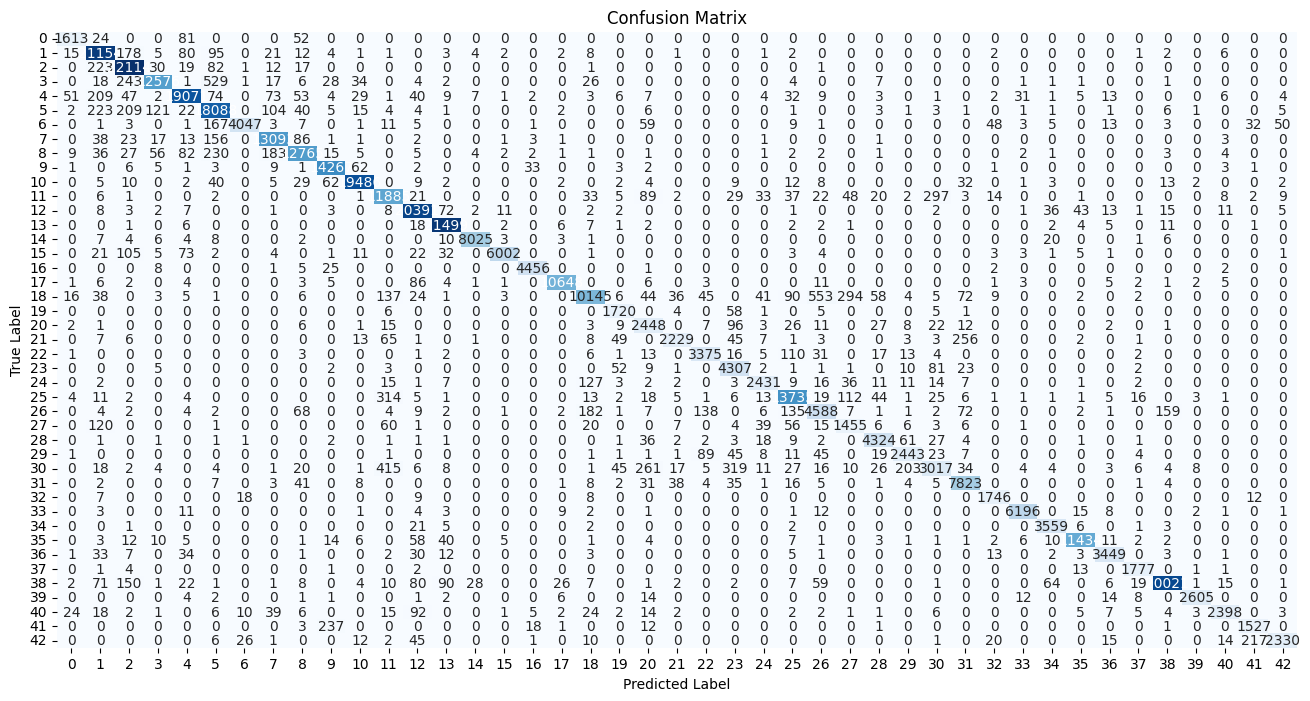

In [ ]:
# Plotting the Confusion Matrix
plt.figure(figsize=(16, 8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CNN with Attention Module, Adam Optimizer and a LR Scheduler
Image Transformations Used:
1. Rotation
2. Random Affiner
3. Color Jitter

Params:
1. Epochs - 30
2. Learning Rate - 0.001

In [ ]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import GTSRB
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Self attention module for GTSRB Classifier Class
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Creating projections
        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, -1, height * width)
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        # Applying attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        # Adding the residual connections
        return self.gamma * out + x

# GTSRB Classifier Class
class GTSRBModelWithAttention(nn.Module):
    def __init__(self):
        super(GTSRBModelWithAttention, self).__init__()

        # Building 3 deep convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Creating 2 Attention layers after 2nd and 3rd convolutional layer
        self.attention1 = SelfAttention(64)
        self.attention2 = SelfAttention(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size of flattened features
        # After 3 pooling layers: 32x32 -> 16x18 -> 8x8 -> 4x4
        self.flatten_size = 128 * 4 * 4

        # Building fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 43)

        # Adding a dropout layer
        self.dropout = nn.Dropout(0.5)

    # for forward propagation
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.attention1(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.attention2(x)
        x = x.view(-1, self.flatten_size)
        x = self.dropout(F.relu(self.bn4(self.fc1(x))))
        x = self.fc2(x)
        return x

# Image transforms while downloaing the dataset
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

# Lists to store loss and accuracy for training and validating dataset
train_losses_sa, test_losses_sa = [], []
train_accuracies_sa, test_accuracies_sa = [], []
all_preds_sa, all_labels_sa = [], []

# function for training the model
def train_model(model, train_loader, test_loader, num_epochs=30):
    # utilizing GPU while training the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initializing the Cross Entropy Loss and Adam Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    best_test_acc = 0.0

    # running the model for 30 epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()


        # Testing/Testing
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                all_preds_sa.extend(predicted.cpu().numpy())
                all_labels_sa.extend(labels.cpu().numpy())


        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        test_loss = test_loss / len(test_loader)
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total

        train_losses_sa.append(train_loss)
        test_losses_sa.append(test_loss)
        train_accuracies_sa.append(train_acc)
        test_accuracies_sa.append(test_acc)

        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')


        # Saving the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model_sa.pth')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.3f}')
        print(f'Training Accuracy: {train_acc:.2f}%')
        print(f'Testing Accuracy: {test_acc:.2f}%')
        print(f'Best Testing Accuracy: {best_test_acc:.2f}%')
        print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}')
        print('--------------------')

        scheduler.step(test_loss)

# 'main' function to handle the execution of program
def main():
    # Loading the datasets
    train_dataset = GTSRB(root='./data', split='train', download=True, transform=train_transforms)
    test_dataset = GTSRB(root='./data', split='test', download=True, transform=test_transforms)

    # Creating the data loaders for training and Testing dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=4,
        drop_last=True
    )

    # Initialize and train model
    model = GTSRBModelWithAttention()
    train_model(model, train_loader, test_loader)

if __name__ == '__main__':
    main()

Epoch [1/30]
Training Loss: 1.045
Training Accuracy: 71.85%
Testing Accuracy: 86.99%
Best Testing Accuracy: 86.99%
Precision: 0.951, Recall: 0.950, F1-Score: 0.950
--------------------
Epoch [2/30]
Training Loss: 0.199
Training Accuracy: 94.54%
Testing Accuracy: 89.51%
Best Testing Accuracy: 89.51%
Precision: 0.951, Recall: 0.950, F1-Score: 0.950
--------------------
Epoch [3/30]
Training Loss: 0.131
Training Accuracy: 96.32%
Testing Accuracy: 91.75%
Best Testing Accuracy: 91.75%
Precision: 0.951, Recall: 0.950, F1-Score: 0.950
--------------------
Epoch [4/30]
Training Loss: 0.096
Training Accuracy: 97.08%
Testing Accuracy: 91.96%
Best Testing Accuracy: 91.96%
Precision: 0.951, Recall: 0.950, F1-Score: 0.950
--------------------
Epoch [5/30]
Training Loss: 0.088
Training Accuracy: 97.38%
Testing Accuracy: 92.79%
Best Testing Accuracy: 92.79%
Precision: 0.951, Recall: 0.950, F1-Score: 0.950
--------------------
Epoch [6/30]
Training Loss: 0.073
Training Accuracy: 97.75%
Testing Accurac

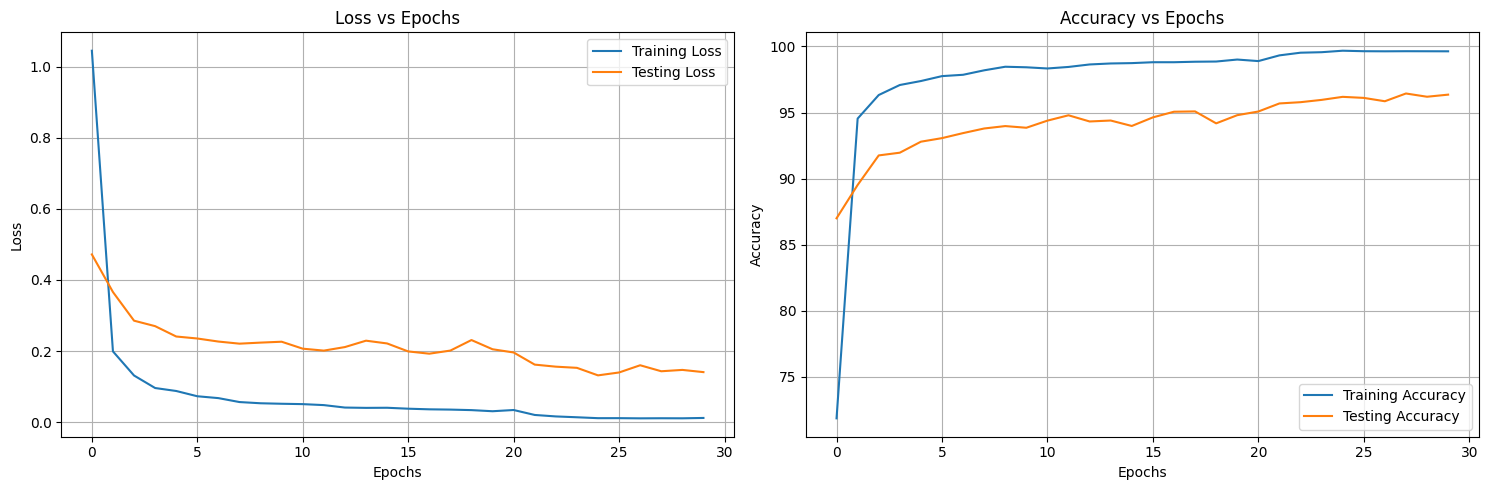

In [ ]:
# Graphs for loss vs epoch and accuracy vs epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses vs epochs
ax1.plot(train_losses_sa, label='Training Loss')
ax1.plot(test_losses_sa, label='Testing Loss')
ax1.set_title('Loss vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies vs epochs
ax2.plot(train_accuracies_sa, label='Training Accuracy')
ax2.plot(test_accuracies_sa, label='Testing Accuracy')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

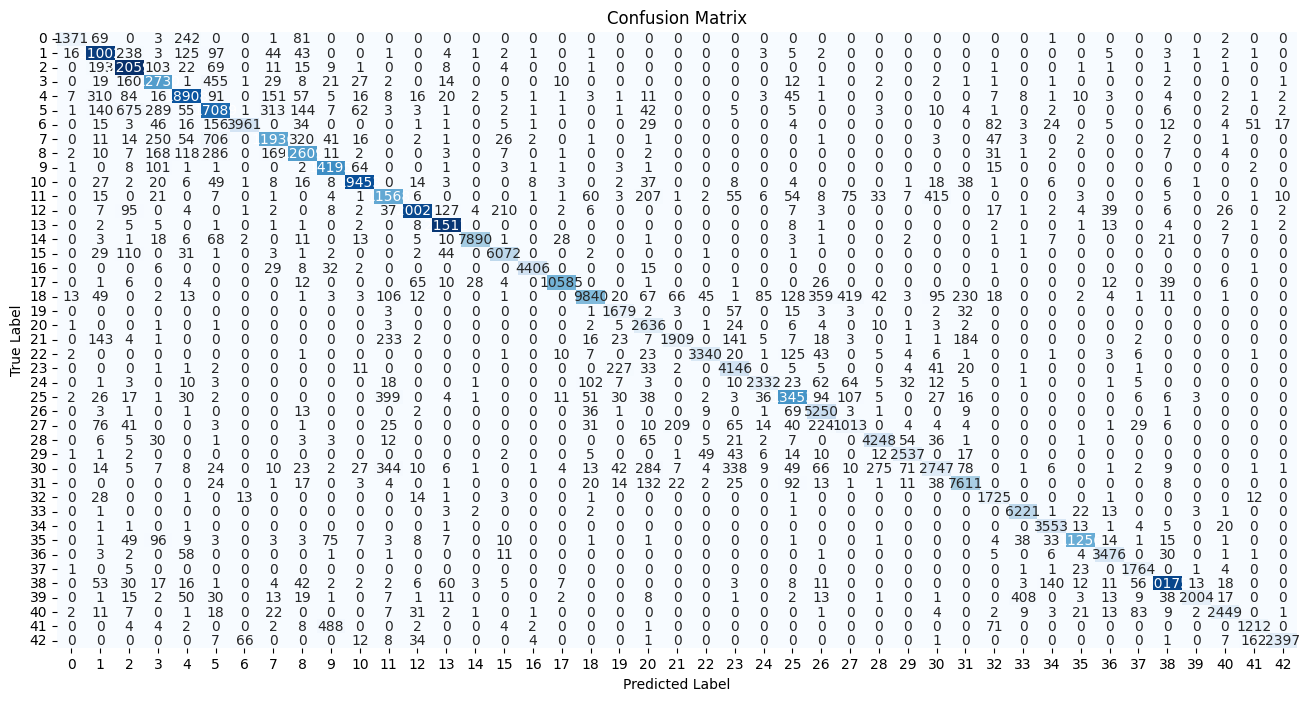

In [ ]:
# Plotting the Confusion Matrix
plt.figure(figsize=(16, 8))
sns.heatmap(confusion_matrix(all_labels_sa, all_preds_sa), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()